# `fastapi`: Monitor NLP models with ArgillaLogHTTPMiddleware

In this tutorial, you'll learn to monitor the predictions of a FastAPI inference endpoint
and log model predictions in an Argilla dataset. It will walk you through 4 basic MLOps Steps:

- 💾 Load the model you want to use.
- 🔄 Convert model output to Argilla format.
- 💻 Create a FastAPI endpoint.
- 🤖 Add middleware to automate logging to Argilla

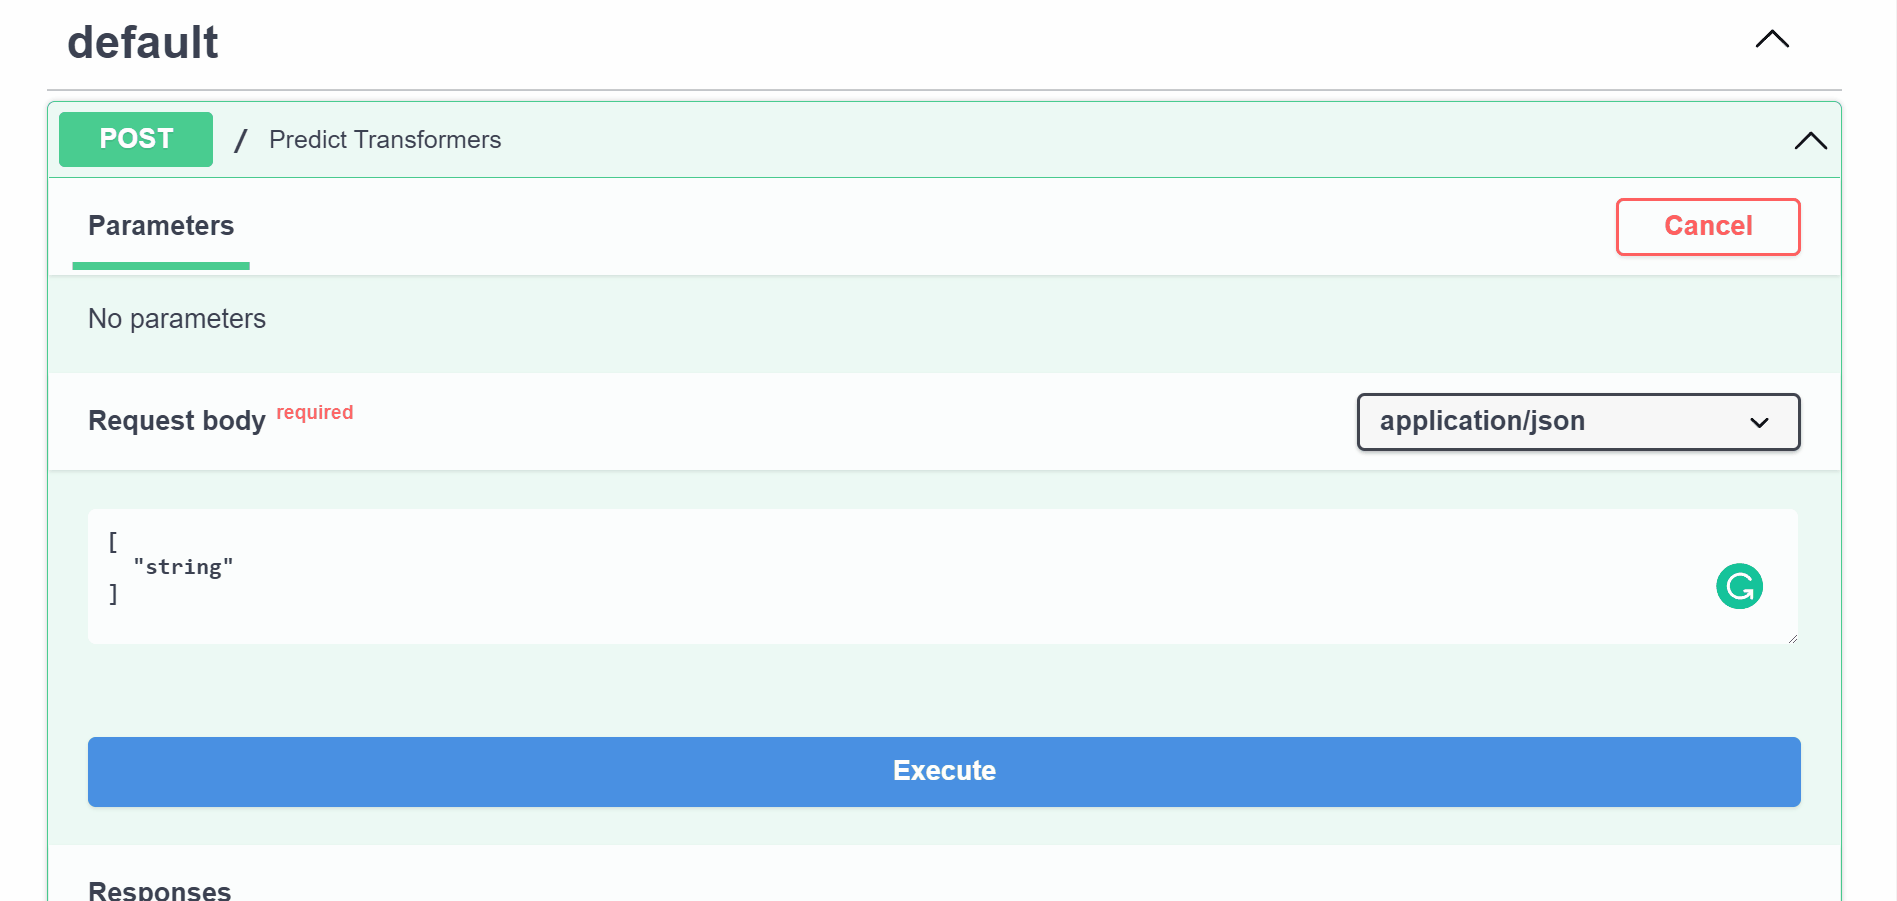

## Introduction
Models are often deployed via an HTTP API endpoint that is called by a client to obtain the model's predictions.
With [FastAPI](https://fastapi.tiangolo.com/) and *Argilla* you can easily monitor those predictions and log them to a *Argilla* dataset.
Due to its human-centric UX, *Argilla* datasets can be comfortably viewed and explored by any team member of your organization.
But *Argilla* also provides automatically computed metrics, both of which help you to keep track of your predictor and spot potential issues early on. 

FastAPI and *Argilla* allow you to deploy and monitor any model you like but in this tutorial, we will focus on the two most common frameworks in the NLP space: [spaCy](https://spacy.io/api/doc) and [transformers](https://huggingface.co/docs/transformers). Let's get started!

## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:


**Deploy Argilla on Hugging Face Spaces**: If you want to run tutorials with external notebooks (e.g., Google Colab) and you have an account on Hugging Face, you can deploy Argilla on Spaces with a few clicks:

[![deploy on spaces](https://huggingface.co/datasets/huggingface/badges/raw/main/deploy-to-spaces-lg.svg)](https://huggingface.co/new-space?template=argilla/argilla-template-space)

For details about configuring your deployment, check the [official Hugging Face Hub guide](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla).


**Launch Argilla using Argilla's quickstart Docker image**: This is the recommended option if you want [Argilla running on your local machine](../../getting_started/quickstart.ipynb). Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip
    
This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or on a Jupyter notebook tool of your choice.
</div>

## Setup

To complete this tutorial, you will need to install the Argilla client and a few third-party libraries using `pip`:

In [ ]:
%pip install argilla fastapi uvicorn[standard] spacy transformers[torch] -qqq

Let's import the Argilla module for reading and writing data:

In [ ]:
import argilla as rg

If you are running Argilla using the Docker quickstart image or Hugging Face Spaces, you need to init the Argilla client with the `URL` and `API_KEY`:

In [ ]:
# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key
rg.init(
    api_url="http://localhost:6900", 
    api_key="admin.apikey"
)

Finally, let's include the imports we need:

In [74]:
from fastapi import FastAPI
import spacy
from transformers import pipeline
from typing import List

# for adding logging to API endpoints
from argilla.monitoring.asgi import (
    ArgillaLogHTTPMiddleware, 
    text_classification_mapper,
    token_classification_mapper,
)

# Instantiate our FastAPI app
app = FastAPI()

## 1. Loading models

As a first step, let's load our models.
For spacy we need to first download the model before we can instantiate a spacy pipeline with it.
Here we use the small English model `en_core_web_sm`, but you can choose any available model on their [hub](https://spacy.io/usage/models).

In [ ]:
!python -m spacy download en_core_web_sm

The "text-classification" pipeline by transformers downloads the model for you and by default it will use the `distilbert-base-uncased-finetuned-sst-2-english` model.
But you can instantiate the pipeline with any compatible model on their [hub](https://huggingface.co/models).

In [76]:
spacy_pipeline = spacy.load("en_core_web_sm")
transformers_pipeline = pipeline("text-classification", return_all_scores=True)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.8/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


For more information about using the `transformers` library with Argilla, check the tutorial [How to label your data and fine-tune a 🤗 sentiment classifier](../../tutorials/notebooks/training-textclassification-transformers-pretrained.ipynb)

### Model output
Let's try the transformer's pipeline in this example:

In [78]:
batch = ["I really like argilla!"]
predictions = transformers_pipeline(batch)
print(predictions)

[[{'label': 'NEGATIVE', 'score': 0.0029897126369178295}, {'label': 'POSITIVE', 'score': 0.9970102310180664}]]


Looks like the `predictions` is a list containing lists of two elements: 
- The first dictionary contains the `NEGATIVE` sentiment label and its score.
- The second dictionary contains the same data but for `POSITIVE` sentiment.

## 2. Convert output to Argilla format
To log the output to Argilla, we should supply a list of dictionaries, each dictionary containing two keys:
- `labels` : value is a list of strings, each string being the label of the sentiment.
- `scores` : value is a list of floats, each float being the probability of the sentiment.

In [79]:
argilla_format = [
    {
        "labels": [p["label"] for p in prediction],
        "scores": [p["score"] for p in prediction],
    }
    for prediction in predictions
]

argilla_format

[{'labels': ['NEGATIVE', 'POSITIVE'],
  'scores': [0.0029897126369178295, 0.9970102310180664]}]

## 3. Create prediction endpoint

In [80]:
# prediction endpoint using transformers pipeline
@app.post("/sentiment/")
def predict_transformers(batch: List[str]):
    predictions = transformers_pipeline(batch)
    return [
        {
            "labels": [p["label"] for p in prediction],
            "scores": [p["score"] for p in prediction],
        }
        for prediction in predictions
    ]

## 4. Add Argilla logging middleware to the application

In [82]:
def text2records(batch: List[str], outputs: List[dict]):
    return [
        text_classification_mapper(data, prediction)
        for data, prediction in zip(batch, outputs)
    ]

app.add_middleware(
    ArgillaLogHTTPMiddleware,
    api_endpoint="/transformers/",  # the endpoint that will be logged
    dataset="monitoring_transformers",  # your dataset name
    records_mapper=text2records, # your post-process func to adapt service inputs and outputs into an Argilla record
)

## 5. NER endpoint with spaCy
We'll add a custom mapper to convert spaCy's output to `TokenClassificationRecord` format

In [83]:
def token2records(batch: List[str], outputs: List[dict]):
    return [
        token_classification_mapper(data, prediction)
        for data, prediction in zip(batch, outputs)
    ]

app.add_middleware(
    ArgillaLogHTTPMiddleware,
    api_endpoint="/spacy/",
    dataset="monitoring_spacy",
    records_mapper=token2records,
)

# prediction endpoint using spacy pipeline
@app.post("/ner/")
def predict_spacy(batch: List[str]):
    predictions = []
    for text in batch:
        doc = spacy_pipeline(text)  # spaCy Doc creation
        # Entity annotations
        entities = [
            {"label": ent.label_, "start": ent.start_char, "end": ent.end_char}
            for ent in doc.ents
        ]

        prediction = {
            "text": text,
            "entities": entities,
        }
        predictions.append(prediction)
    return predictions

Now we can add a method to check if the server is up and running:

In [85]:
@app.get("/")
def root():
    return {"message": "alive"}

## Launching and testing the API

To launch the application, copy the whole code into a file named `main.py` (you can find the full file content in the appendix.

Once you have created the file, you can run the following command. We add the nohup command in case you are running this on Colab, but you can remove it otherwise:

In [ ]:
!nohup uvicorn main:app

### Testing our endpoint and prediction logging

If we now start calling our API, our model inputs and outputs should be logged into their corresponding Argilla Datasets

In [8]:
import requests

response = requests.post(
    "http://localhost:8000/sentiment/", 
    json=["I like Argilla", "I hated data labelling but now I don't"]
)

response.content

b'[{"labels":["NEGATIVE","POSITIVE"],"scores":[0.8717259168624878,0.128274068236351]},{"labels":["NEGATIVE","POSITIVE"],"scores":[0.9916356801986694,0.008364332839846611]}]'

If everything went well you should see two new records on your Argilla `monitoring_transformers` dataset.

## Summary

In this tutorial, we learned to automatically log model inputs and outputs into Argilla.
This can be used to continuously and transparently monitor HTTP inference endpoints.

## Apendix: `main.py` full code

In [31]:
import argilla

from fastapi import FastAPI

from typing import List

import spacy

from transformers import pipeline

from argilla.monitoring.asgi import (
    ArgillaLogHTTPMiddleware, 
    text_classification_mapper,
    token_classification_mapper,
)

spacy_pipeline = spacy.load("en_core_web_sm")
transformers_pipeline = pipeline("text-classification", return_all_scores=True)

app = FastAPI()

# prediction endpoint using transformers pipeline
@app.post("/sentiment/")
def predict_transformers(batch: List[str]):
    predictions = transformers_pipeline(batch)
    return [
        {
            "labels": [p["label"] for p in prediction],
            "scores": [p["score"] for p in prediction],
        }
        for prediction in predictions
    ]

def text2records(batch: List[str], outputs: List[dict]):
    return [
        text_classification_mapper(data, prediction)
        for data, prediction in zip(batch, outputs)
    ]

app.add_middleware(
    ArgillaLogHTTPMiddleware,
    api_endpoint="/transformers/",  # the endpoint that will be logged
    dataset="monitoring_transformers",  # your dataset name
    records_mapper=text2records, # your post-process func to adapt service inputs and outputs into an Argilla record
)

def token2records(batch: List[str], outputs: List[dict]):
    return [
        token_classification_mapper(data, prediction)
        for data, prediction in zip(batch, outputs)
    ]

# prediction endpoint using spacy pipeline
@app.post("/ner/")
def predict_spacy(batch: List[str]):
    predictions = []
    for text in batch:
        doc = spacy_pipeline(text)  # spaCy Doc creation
        # Entity annotations
        entities = [
            {"label": ent.label_, "start": ent.start_char, "end": ent.end_char}
            for ent in doc.ents
        ]

        prediction = {
            "text": text,
            "entities": entities,
        }
        predictions.append(prediction)
    return predictions

app.add_middleware(
    ArgillaLogHTTPMiddleware,
    api_endpoint="/ner/",
    dataset="monitoring_spacy",
    records_mapper=token2records,
)

app.add_middleware(
    ArgillaLogHTTPMiddleware,
    api_endpoint="/sentiment/",
    dataset="monitoring_transformers",
    records_mapper=text2records,
)

@app.get("/")
def root():
    return {"message": "alive"}

argilla.init(
    api_url="http://localhost:6900", 
    api_key="admin.apikey"
)